In [48]:
import numpy as np
import pandas as pd
import re
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, accuracy_score, roc_curve, silhouette_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from lime.lime_text import LimeTextExplainer
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
from textblob import TextBlob
import time
from sklearn.cluster import KMeans
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [49]:
# Load CSV data
data = pd.read_csv("C:/Users/Dell/OneDrive/Desktop/sem 3/NLP/ass-4/Sentiment_Data.csv",encoding='ISO-8859-1',nrows=6000)  # Ensure your CSV has 'Sentiment', 'Count', 'text', and 'label' columns

In [50]:
data.head()

,Tweet,Sentiment
0,@_angelica_toy Happy Anniversary!!!....The Day...,Mild_Pos
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,Mild_Pos
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,Mild_Pos
3,@NChartierET Happy Anniversary!!!....The Day t...,Mild_Pos
4,@tabithapeters05 Happy Anniversary!!!....The D...,Mild_Pos


In [51]:
data.shape

(6000, 2)

In [52]:
# Sentiment Mapping
sentiment_mapping = {
    'Strong_Pos': 'Positive',
    'Mild_Pos': 'Positive',
    'Strong_Neg': 'Negative',
    'Mild_Neg': 'Negative',
    'Neutral': 'Neutral'
}

In [53]:
data['Simplified_Sentiment'] = data['Sentiment'].map(sentiment_mapping)

In [54]:
# Fill missing values in 'Tweet' column with an empty string to avoid errors
data['Tweet'] = data['Tweet'].fillna('')

In [55]:
# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [56]:
# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [57]:
# Extended contraction dictionary
contractions = {
    "can't": "cannot", "won't": "will not", "n't": " not", "'re": " are", "'s": " is", "'d": " would",
    "'ll": " will", "'t": " not", "'ve": " have", "'m": " am", "i'm": "i am", "you're": "you are",
    "we're": "we are", "they're": "they are", "it's": "it is", "that's": "that is", "there's": "there is"
}

In [58]:
def clean_text(text):
    # 1. Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # 2. Remove mentions but keep hashtags
    text = re.sub(r'\@\w+', '', text)
    # 3. Handle contractions
    for contraction, expanded in contractions.items():
        text = re.sub(r"\b{}\b".format(re.escape(contraction)), expanded, text)
    # 4. Remove punctuation and special characters (but keep #)
    text = re.sub(r'[^A-Za-z0-9\s#]', '', text)
    # 5. Tokenize text and remove stop words
    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]
    # 6. Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    # 7. Convert to lowercase
    text = ' '.join(words).lower()

    return text

In [59]:
data['cleaned_text'] = data['Tweet'].apply(clean_text)

In [60]:
# Emoji Handling
def handle_emoji(text):
    return emoji.demojize(text, delimiters=(" ", " "))

In [61]:
data['emoji_handled_text'] = data['cleaned_text'].apply(handle_emoji)

In [62]:
slang_dict = {
    'afaik': 'as far as I know',
    'b4': 'before',
    'b/c': 'because',
    'brb': 'be right back',
    'btw': 'by the way',
    'cya': 'see you',
    'dm': 'direct message',
    'fomo': 'fear of missing out',
    'ftw': 'for the win',
    'fyi': 'for your information',
    'gr8': 'great',
    'gtg': 'got to go',
    'hbu': 'how about you',
    'hmu': 'hit me up',
    'idc': 'I don’t care',
    'idk': "I don't know",
    'ikr': 'I know right',
    'imo': 'in my opinion',
    'imho': 'in my humble opinion',
    'irl': 'in real life',
    'jk': 'just kidding',
    'l8r': 'later',
    'lmao': 'laughing my ass off',
    'lmfao': 'laughing my f***ing ass off',
    'lol': 'laughing out loud',
    'msg': 'message',
    'np': 'no problem',
    'nvm': 'never mind',
    'omg': 'oh my god',
    'omw': 'on my way',
    'pls': 'please',
    'plz': 'please',
    'rofl': 'rolling on the floor laughing',
    'smh': 'shaking my head',
    'tbh': 'to be honest',
    'tbt': 'throwback Thursday',
    'ttyl': 'talk to you later',
    'u': 'you',
    'ur': 'your',
    'w/e': 'whatever',
    'w/o': 'without',
    'wbu': 'what about you',
    'wyd': 'what you doing',
    'wtf': 'what the f***',
    'yolo': 'you only live once',
    'y/w': 'you’re welcome',
    'yt': 'YouTube',
    'bff': 'best friend forever',
    'gonna': 'going to',
    'gotta': 'got to',
    'wanna': 'want to',
    'luv': 'love',
    'tho': 'though',
    'abt': 'about',
    '2day': 'today',
    '2moro': 'tomorrow',
    '2nite': 'tonight',
    'pic': 'picture',
    'ppl': 'people',
    'thx': 'thanks',
    'grats': 'congratulations',
    'gr8': 'great',
    'jk': 'just kidding',
    'fam': 'family or close friends',
    'bruh': 'brother or dude',
    'sus': 'suspicious',
    'lit': 'exciting or excellent',
    'savage': 'bold or aggressive',
    'bae': 'before anyone else (significant other)',
    'dope': 'cool or impressive',
    'fomo': 'fear of missing out',
    'fam': 'family or friends',
    'shade': 'disrespect or criticism',
    'stan': 'an extremely devoted fan',
    'snatched': 'looks good or on point',
    'thirsty': 'desperate or attention-seeking'
}

In [63]:
abbreviations_dict = {
    'afaik': 'as far as I know',
    'b/c': 'because',
    'b4': 'before',
    'bff': 'best friend forever',
    'brb': 'be right back',
    'btw': 'by the way',
    'cya': 'see you',
    'dm': 'direct message',
    'fb': 'Facebook',
    'fomo': 'fear of missing out',
    'ftw': 'for the win',
    'fyi': 'for your information',
    'g2g': 'got to go',
    'gg': 'good game',
    'hmu': 'hit me up',
    'idc': "I don't care",
    'idk': "I don't know",
    'ikr': 'I know right',
    'ily': 'I love you',
    'imo': 'in my opinion',
    'imho': 'in my humble opinion',
    'irl': 'in real life',
    'jk': 'just kidding',
    'l8r': 'later',
    'lmk': 'let me know',
    'lmao': 'laughing my ass off',
    'lmfao': 'laughing my freaking ass off',
    'lol': 'laughing out loud',
    'msg': 'message',
    'nbd': 'no big deal',
    'np': 'no problem',
    'nvm': 'never mind',
    'omg': 'oh my god',
    'omw': 'on my way',
    'pls': 'please',
    'plz': 'please',
    'rofl': 'rolling on the floor laughing',
    'smh': 'shaking my head',
    'tbh': 'to be honest',
    'tbt': 'throwback Thursday',
    'ttyl': 'talk to you later',
    'u': 'you',
    'ur': 'your',
    'w/e': 'whatever',
    'w/o': 'without',
    'wbu': 'what about you',
    'wyd': 'what you doing',
    'wtf': 'what the freak',
    'yolo': 'you only live once',
    'yw': "you're welcome",
    'yt': 'YouTube',
    'asap': 'as soon as possible',
    'bday': 'birthday',
    'bc': 'because',
    'cuz': 'because',
    'fam': 'family',
    'fb': 'Facebook',
    'gf': 'girlfriend',
    'bf': 'boyfriend',
    'gr8': 'great',
    'imo': 'in my opinion',
    'imho': 'in my humble opinion',
    'irl': 'in real life',
    'jk': 'just kidding',
    'np': 'no problem',
    'nvm': 'never mind',
    'omw': 'on my way',
    'r': 'are',
    'ttyl': 'talk to you later',
    'wanna': 'want to',
    'gonna': 'going to',
    'gotta': 'got to',
    'thx': 'thanks',
    'thnx': 'thanks',
    'bffl': 'best friend for life',
    'ily': 'I love you',
    'atm': 'at the moment',
    'bruh': 'brother',
    'b4n': 'bye for now',
    'bb': 'bye bye',
    'bt': 'but',
    'btwn': 'between',
    'cu': 'see you',
    'ez': 'easy',
    'gratz': 'congratulations',
    'gr8': 'great',
    'hbd': 'happy birthday',
    'imo': 'in my opinion',
    'imma': "I'm going to",
    'j/k': 'just kidding',
    'k': 'okay',
    'lil': 'little',
    'ltns': 'long time no see',
    'm8': 'mate',
    'msg': 'message',
    'mssg': 'message',
    'n1': 'nice one',
    'nc': 'no comment',
    'noob': 'newbie',
    'nm': 'not much',
    'omg': 'oh my god',
    'otw': 'on the way',
    'ppl': 'people',
    'rly': 'really',
    'sup': 'what’s up',
    'tldr': 'too long didn’t read',
    'txt': 'text',
    'wth': 'what the heck',
    'xoxo': 'hugs and kisses',
    'y': 'why',
    'yeet': 'throw with force',
    'zzz': 'sleepy or bored'
}

In [64]:
def handle_slang_and_abbr(text):
    words = text.split()
    words = [slang_dict.get(word.lower(), abbreviations_dict.get(word.lower(), word)) for word in words]
    return ' '.join(words)

In [65]:
data['slang_abbr_handled_text'] = data['emoji_handled_text'].apply(handle_slang_and_abbr)

In [66]:
# A dictionary of antonyms for handling common negations
antonym_dict = {
    'good': 'bad',
    'happy': 'sad',
    'easy': 'difficult',
    'interesting': 'boring',
    'smart': 'dull',
    'like': 'dislike',
    'love': 'hate',
    'success': 'failure',
    'strong': 'weak',
    'possible': 'impossible',
    'safe': 'dangerous'
}

In [67]:
def handle_negation(text):
    # Pattern to match phrases like "not good", "never easy", "no love"
    negation_pattern = r'\b(not|never|no)\s+(\w+)\b'
    
    def replace_with_antonym(match):
        negation, word = match.groups()
        # Replace with antonym if available; otherwise, keep the original phrase
        return antonym_dict.get(word, f"{negation} {word}")
    
    # Substitute negated phrases with their antonyms if available
    text = re.sub(negation_pattern, replace_with_antonym, text)
    
    return text

In [68]:
data['processed_text'] = data['slang_abbr_handled_text'].apply(handle_negation)

In [69]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [70]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

def get_sentiment_vader(text):
    sentiment_scores = sia.polarity_scores(text)
    polarity = sentiment_scores['compound']  # Overall polarity from -1 to 1
    subjectivity = abs(sentiment_scores['pos'] - sentiment_scores['neg'])  # Approximate subjectivity
    return polarity, subjectivity

In [71]:
# Assuming `data` is your DataFrame with a column 'processed_text'
data[['polarity', 'subjectivity']] = data['processed_text'].apply(lambda x: pd.Series(get_sentiment_vader(x)))

In [72]:
# Encode target variable (assuming 'Positive', 'Neutral', 'Negative')
label_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
data['encoded_label'] = data['Simplified_Sentiment'].map(label_mapping)

In [73]:
# Perform train-test split directly on the DataFrame while ensuring >5000 samples in the test set
train_data, test_data = train_test_split(data, test_size=0.20, random_state=42)

In [74]:
# Verify test set size
print("Test set size:", len(test_data))
assert len(test_data) > 1000, "Test set must have more than 5000 samples."

Test set size: 1200


In [75]:
# Apply sentiment feature engineering only after splitting
train_data[['polarity', 'subjectivity']] = train_data['processed_text'].apply(lambda x: pd.Series(get_sentiment_vader(x)))
test_data[['polarity', 'subjectivity']] = test_data['processed_text'].apply(lambda x: pd.Series(get_sentiment_vader(x)))

In [76]:
# Extract text and label columns for training and testing
X_train_text = train_data['processed_text'].values
X_test_text = test_data['processed_text'].values
y_train = train_data['encoded_label'].values
y_test = test_data['encoded_label'].values

In [77]:
# Extract the sentiment features for scaling and PCA
train_sentiment = train_data[['polarity', 'subjectivity']]
test_sentiment = test_data[['polarity', 'subjectivity']]

In [78]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)  # Fit tokenizer on training data only
sequences = tokenizer.texts_to_sequences(X_train_text)

# Calculate 90th percentile length for padding
lengths = [len(seq) for seq in sequences]
max_length = int(np.percentile(lengths, 90))  # Set max length as the 90th percentile
print("Chosen max_length:", max_length)

Chosen max_length: 24


In [79]:
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train_text), maxlen=100, padding='post')
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test_text), maxlen=100, padding='post')

In [80]:
# Scaling and PCA on sentiment features
scaler = StandardScaler()
train_sentiment_scaled = scaler.fit_transform(train_sentiment)  # Fit on training data only
test_sentiment_scaled = scaler.transform(test_sentiment)        # Transform test data with the same scaler

pca = PCA(n_components=2)
train_sentiment_pca = pca.fit_transform(train_sentiment_scaled)  # Fit PCA on training data only
test_sentiment_pca = pca.transform(test_sentiment_scaled)        # Transform test data with the same PCA

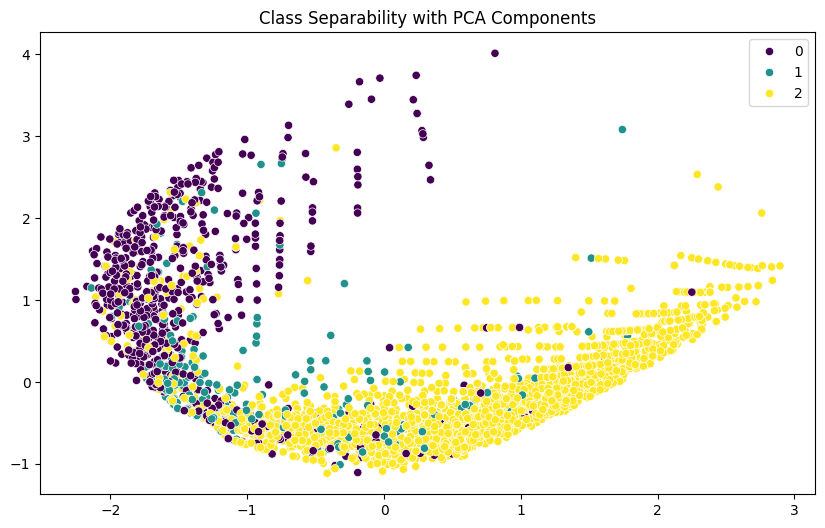

In [81]:
# Create a copy of the sentiment data from the training subset to avoid SettingWithCopyWarning
train_sentiment = train_data[['polarity', 'subjectivity']].copy()
test_sentiment = test_data[['polarity', 'subjectivity']].copy()

# Encode the target variable for class separability check
label_encoder = LabelEncoder()
train_sentiment['target_encoded'] = label_encoder.fit_transform(y_train)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_sentiment_pca[:, 0], y=train_sentiment_pca[:, 1], hue=y_train, palette='viridis')
plt.title("Class Separability with PCA Components")
plt.show()

In [82]:
# Calculate silhouette score after performing KMeans clustering
kmeans = KMeans(n_clusters=len(np.unique(y_train)), random_state=42)

# Explicitly assign cluster labels with .loc to avoid the warning
train_sentiment.loc[:, 'cluster_labels'] = kmeans.fit_predict(train_sentiment[['polarity', 'subjectivity']])

# Calculate the silhouette score
silhouette_avg = silhouette_score(train_sentiment[['polarity', 'subjectivity']], train_sentiment['cluster_labels'])
print(f"Silhouette Score for 'polarity' and 'subjectivity': {silhouette_avg}")


Silhouette Score for 'polarity' and 'subjectivity': 0.591498289291231


In [83]:
# Bidirectional LSTM Model for 3-class classification
embedding_dim = 128
lstm_units = 64
dropout_rate = 0.5
vocab_size = 20000

In [84]:
model = Sequential([
    Input(shape=(max_length,)),  # Define input shape in a separate Input layer
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(lstm_units, return_sequences=True)),
    Dropout(dropout_rate),
    Bidirectional(LSTM(lstm_units)),
    Dense(3, activation='softmax')  # 3 output units for Positive, Neutral, and Negative
])

In [85]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 24, 128)             │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 24, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,758,019 (10.52 MB)

 Trainable params: 2,758,019 (10.52 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [87]:
# Model Training and Evaluation
start_time = time.time()
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=128, validation_data=(X_test_padded, y_test), verbose=1)

Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 447ms/step - accuracy: 0.6029 - loss: 0.9035 - val_accuracy: 0.6992 - val_loss: 0.7472
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 439ms/step - accuracy: 0.7420 - loss: 0.6482 - val_accuracy: 0.7650 - val_loss: 0.6201
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 459ms/step - accuracy: 0.8653 - loss: 0.3788 - val_accuracy: 0.7450 - val_loss: 0.6654
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 534ms/step - accuracy: 0.9387 - loss: 0.1911 - val_accuracy: 0.7383 - val_loss: 0.7628
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 544ms/step - accuracy: 0.9684 - loss: 0.1061 - val_accuracy: 0.7108 - val_loss: 0.9625


In [88]:
train_time = time.time() - start_time
print(f"Training Time: {train_time:.2f} seconds")
train_time_minutes = train_time / 60
print(f"Training Time: {train_time_minutes:.2f} minutes")

Training Time: 101.38 seconds
Training Time: 1.69 minutes


In [89]:
import pickle

# Save the trained LSTM model
model.save('C:/Users/Dell/OneDrive/Desktop/sem 3/deploymnet/Final Presentation/lstm_model.h5')

# Save the tokenizer
with open('C:/Users/Dell/OneDrive/Desktop/sem 3/deploymnet/Final Presentation/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
